In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

from itertools import product

import numpy as np
import pandas as pd
import cvxopt
import cvxopt.solvers

import matplotlib
import matplotlib.pyplot as plt

cvxopt.solvers.options['show_progress'] = False

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)

In [2]:
chips_df = pd.read_csv('data/chips.csv')
geyser_df = pd.read_csv('data/geyser.csv')

In [3]:
def transform_data(df: pd.DataFrame) -> np.ndarray:
    scaler = StandardScaler()
    scaler.fit(df[['x', 'y']])
    
    X = scaler.transform(df[['x', 'y']])
    y = np.vectorize(lambda x: 1 if x == 'P' else -1)(df['class'])
    
    return X, y

In [4]:
X_chips, y_chips = transform_data(chips_df)
len(y_chips)

118

In [5]:
X_geyser, y_geyser = transform_data(geyser_df)
len(y_geyser)

222

In [6]:
# define kernel functions

class KernelMixin:
    
    def __init__(self, kernel_name, degree, beta, b, gamma):
        _name_to_function = {
            'linear': KernelMixin.linear_kernel,
            'poly': KernelMixin.polynomial_kernel,
            'rbf': KernelMixin.gaussain_kernel,
        }
        self.kernel_fn = _name_to_function[kernel_name]
        self.degree = degree
        self.gamma = gamma
        self.beta = beta
        self.b = b
    
    def calculate_kernel_matrix(self, X, y):
        Q = np.zeros((len(X), len(X)))
        
        for i, (x_i, y_i) in enumerate(zip(X, y)):
            for j, (x_j, y_j) in enumerate(zip(X, y)):
                Q[i, j] = y_i * y_j * self.kernel_fn(self, x_i, x_j)
                
        return Q
    
    def linear_kernel(self, x, y):
        return np.dot(x, y)
    
    def polynomial_kernel(self, x, y):
        return np.power(self.b + np.dot(x, y) * self.gamma, self.degree)
    
    def gaussain_kernel(self, x, y):
        return np.exp(-1 * self.beta * np.power(np.linalg.norm(x - y), 2))

In [7]:
class SupportVectorMachine(KernelMixin):
        
    def __init__(self, kernel_name, degree=2, beta=4, C=1.0, b=1.0, gamma=1.0):
        super().__init__(kernel_name, degree, beta, b, gamma)
        self.kernel_name = kernel_name
        self.C = C
        self.w_ = None
        self.w0_ = None
    
    def fit(self, X, y):   
        # 0.5 * lambda.T @ Q @ lambda - e.T @ lambda -> min lambda
        Q = self.calculate_kernel_matrix(X, y)
        e = -1 * np.ones((len(y), 1))
        
        # 0 <= lambda <= Ce
        G = np.vstack((-1 * np.eye(len(y)), np.eye(len(y))))
        h = np.hstack((np.zeros(len(y)), self.C * np.ones(len(y))))
        
        # y.T @ x = 0
        y_t = y.reshape(1, -1) * 1.
        b = np.zeros(1)
        
        solution = cvxopt.solvers.qp(
            cvxopt.matrix(Q), cvxopt.matrix(e), 
            cvxopt.matrix(G), cvxopt.matrix(h), 
            cvxopt.matrix(y_t), cvxopt.matrix(b)
        )
        lambdas = np.array(solution['x'])
        
        supports = (lambdas > 1e-4).flatten()
        
        # w = sum_i{lambda_i * y_i * x_i}
        self.w_ = (lambdas.flatten() * y).reshape(1, -1) @ X
        # median over support vectors
        intecepts = np.dot(X[supports, :], self.w_.transpose(1, 0)).reshape(-1) - y[supports]
        self.w0_ = np.median(intecepts)
        
        # Save for predict phase
        self.X = X
        self.y = y
        self.lambdas = lambdas.flatten()
        self.supports = supports
                
    def predict(self, X_sample):
        if self.kernel_name == 'rbf':
            ys = self.lambdas * self.y.reshape(1, -1)
            xs = np.zeros((len(self.X), len(X_sample)))
            
            for i, x in enumerate(self.X):
                for j, s in enumerate(X_sample):
                    xs[i, j] = self.kernel_fn(self, x, s)
            
            res = self.lambdas * self.y.reshape(1, -1) @ xs
            return np.where(res - self.w0_ > 0, 1, -1).flatten()
        else:
            res = self.lambdas * self.y.reshape(1, -1) @ self.kernel_fn(self, self.X, X_sample.transpose(1, 0))
            return np.where(res - self.w0_ > 0, 1, -1).flatten()

In [10]:
Cs = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
degrees = [2, 3, 4, 5]
betas = [1, 2, 3, 4, 5]
gammas = [0.01, 0.5, 1.0]
ks = [0, 0.5, 1]
linear_config = [
    {'kernel_name': 'linear', "C":c, 'beta': None, 
     'degree': None, 'gamma': None, 'b': None} for c in Cs]
poly_config = [
    {'kernel_name': 'poly', 'degree': d, 'C': c, 'beta': None, 'degree': d, 'gamma': g, 'b': k} 
    for c, d, g, k in product(Cs, degrees, gammas, ks)]
rbf_config = [{'kernel_name': 'rbf', 'beta': b, 'C': c} for c, b in product(Cs, betas)]
configs = linear_config + poly_config + rbf_config

In [11]:
for df in [chips_df, geyser_df]:
    X, y = transform_data(df)
    
    best_mean_score = -1
    best_std_score = None
    best_config = None
    
    for config in tqdm(configs):
        kf = KFold(4)
        scores = list()
        
        for train_idx, test_idx in kf.split(X):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]
            
            model = SupportVectorMachine(**config)
            model.fit(X_train, y_train)
            y_hat = model.predict(X_test)
            
            score = accuracy_score(y_test, y_hat)
            scores.append(score)
            
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        
        if mean_score > best_mean_score:
            best_mean_score = mean_score
            best_std_score = std_score
            best_config = config
        
    print(best_config)
    print(f'Score: {best_mean_score*100}+-{best_std_score*100}%')


{'kernel_name': 'poly', 'degree': 4, 'C': 100.0, 'beta': None, 'gamma': 0.5, 'b': 0.5}
Score: 80.7183908045977+-19.85087338126984%



{'kernel_name': 'poly', 'degree': 2, 'C': 1.0, 'beta': None, 'gamma': 1.0, 'b': 0.5}
Score: 90.99837662337661+-2.161637376366592%


In [13]:
def visualize_model(model, X, y):
    h = .02  # step size in the mesh
    
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() -0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    zz = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
#     print(sum(zz.flatten() == 1))

    # Put the result into a color plot
    plt.contourf(xx, yy, zz, cmap=plt.cm.coolwarm, alpha=0.8)
    
    x0, y0 = X[y == -1].T
    x1, y1 = X[y == 1].T
    
    plt.scatter(x0, y0, color='blue', s=100)
    plt.scatter(x1, y1, color='red', s=100)
    
    X_sup = X[model.supports]
    x_sup, y_sup = X_sup.T
    
    plt.scatter(x_sup, y_sup, color='white', marker='x', s=60)
    
    plt.show()

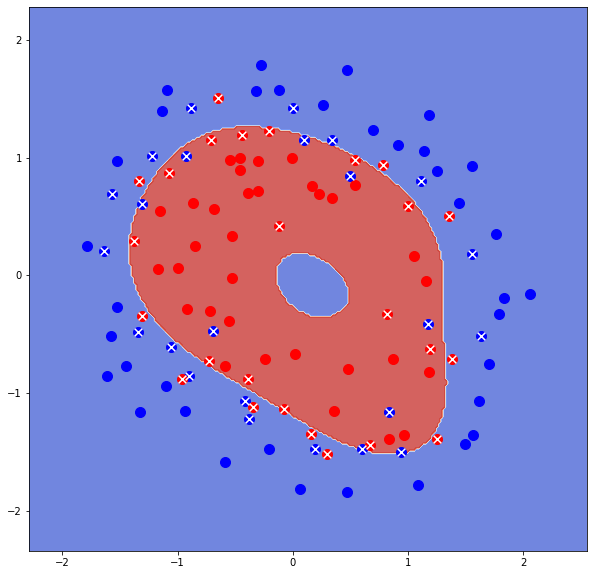

In [16]:
model = SupportVectorMachine(kernel_name='poly', degree=4, C=100, gamma=0.5, b=0.5)
X_chips, y_chips = transform_data(chips_df)
model.fit(X_chips, y_chips)
visualize_model(model, X_chips, y_chips)

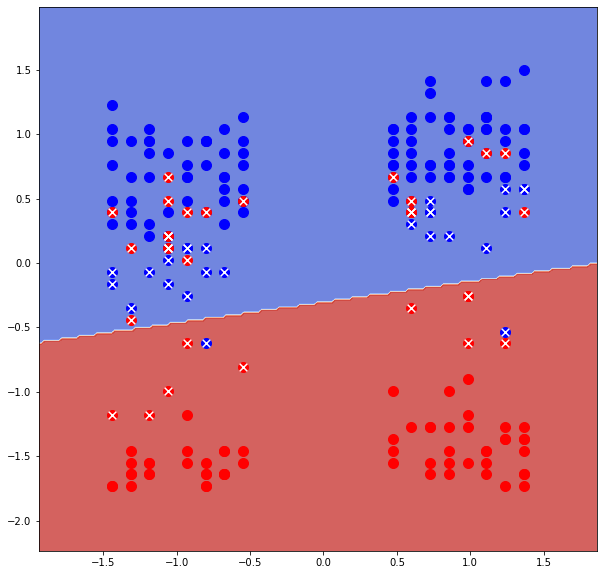

In [17]:
model = SupportVectorMachine(kernel_name='linear', C=1.)
X_geyser, y_geyser = transform_data(geyser_df)
model.fit(X_geyser, y_geyser)
visualize_model(model, X_geyser, y_geyser)

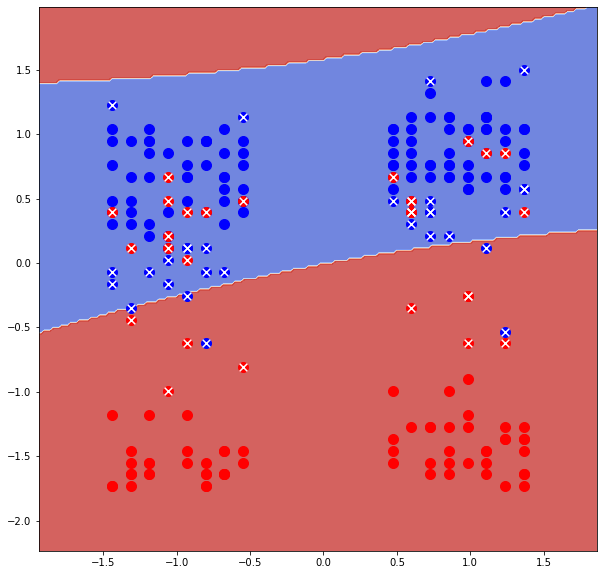

In [18]:
model = SupportVectorMachine(kernel_name='poly', degree=2, C=1, gamma=1., b=0.5)
X_geyser, y_geyser = transform_data(geyser_df)
model.fit(X_geyser, y_geyser)
visualize_model(model, X_geyser, y_geyser)